In [1]:
import numpy as np 
import pandas as pd
import scipy as sp
import kagglehub
from sklearn.metrics.pairwise import cosine_similarity
import pygsp
from pygsp import graphs, filters, plotting
import matplotlib.pyplot as plt
import gower

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
# Download latest version of customer churn data
data_path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")

In [60]:
df = pd.read_csv(data_path + "/customer_churn_telecom_services.csv")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [61]:
# churn is our target so remove it from the data but save it for later
churn = df['Churn']
data = df.iloc[:,:-1]
# one hot encoding of categorical variables, and fill NaN values
#one_hot = pd.get_dummies(df).ffill()
# Calculate cosine similarity between values
#A = cosine_similarity(one_hot)
A = gower.gower_matrix(data)


In [63]:
# build 5-nearest neighbor graph adjacency matrix
W = np.nan_to_num(A)
np.fill_diagonal(W, 0)  # Remove self-loops

# Get indices of the 5 largest values per row
top_k = 5  # Number of neighbors to keep
top_k_indices = np.argsort(W, axis=1)[:, -top_k:]  # Indices of top 5 values per row

# Create a mask to keep only these values
mask = np.zeros_like(W, dtype=bool)
np.put_along_axis(mask, top_k_indices, True, axis=1)

# Apply mask to retain only the 5 largest values per row
W_sparse = np.zeros_like(W)  # Create a zero matrix
W_sparse[mask] = W[mask]  # Copy only the top 5 values

In [56]:
W_sparse

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(7043, 7043), dtype=float32)

In [65]:
nan_positions = np.argwhere(np.isnan(W_sparse))
nan_positions

array([], shape=(0, 2), dtype=int64)

In [66]:
G = pygsp.graphs.Graph(W_sparse)

In [67]:
G.set_coordinates(kind='ring2D')

In [68]:
# set one class to 1 and the other to -1
churn_signal = np.array([1 if c == 'Yes' else -1 for c in churn])

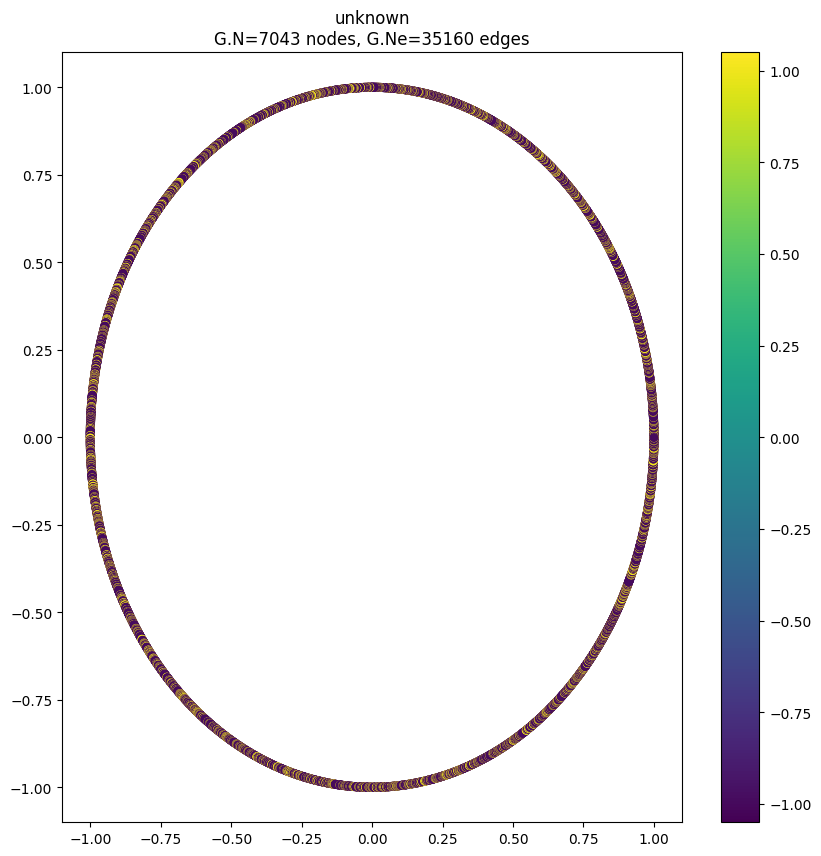

In [69]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
G.plot_signal(churn_signal, vertex_size=30, ax=axes)

In [70]:
# split signal into knowns and unknowns
choice = np.random.choice(range(churn_signal.shape[0]), size=(2100,), replace=False)    
ind = np.zeros(churn_signal.shape[0], dtype=bool)
ind[choice] = True
rest = ~ind
known_signal = np.array([c if i else 0 for c,i in zip(churn_signal, ind)])
unknown_signal = np.array([c if ~i else 0 for c,i in zip(churn_signal, ind)])



In [71]:
#get training signal from known_signals
train_index = np.array(np.where(ind))
choice_train = np.random.choice(range(train_index.shape[1]), size=(700,), replace=False)    
ind_train = np.zeros(churn_signal.shape[0], dtype=bool)
ind_train[choice_train] = True
train_signal = np.array([c if i else 0 for c,i in zip(known_signal, ind_train)])
train_signal

array([0, 0, 0, ..., 0, 0, 0], shape=(7043,))

In [72]:

# setup target func for optimization
L = 4
D = np.diag(known_signal)
one_signal = np.ones(known_signal.shape)

def compute_shifted_signal_vec(D, W, s, L):
    n = len(s)
    # Initialize matrix to store results
    result = np.zeros((L + 1, n))
    
    # For W^0 * s (which is just s)
    current_product = s.copy()
    
    # Apply D (either as diagonal matrix or vector)
    if D.ndim == 2:  # D is a diagonal matrix
        result[0] = D @ current_product
    else:  # D is a vector
        result[0] = D * current_product
    
    # Calculate remaining terms incrementally
    for k in range(1, L + 1):
        # Update to W^k * s directly from W^(k-1) * s
        current_product = W @ current_product
        
        # Apply D (either as diagonal matrix or vector)
        if D.ndim == 2:  # D is a diagonal matrix
            result[k] = D @ current_product
        else:  # D is a vector
            result[k] = D * current_product
    
    return result
shifted_signal_eval = compute_shifted_signal_vec(D, W_sparse, train_signal, L)


In [73]:
def customer_churn_optimal(h):
    return shifted_signal_eval.T.astype(float) @ h - one_signal

In [74]:
trained_filter = sp.optimize.least_squares(customer_churn_optimal, np.ones((L+1,)))

In [75]:
trained_filter.x

array([ 0.95174442,  0.24570277, -0.04167304,  0.01189654,  0.01288241])

In [76]:
# build prediction filter 
def compute_prediction_filter(W, L, h):
    # For W^0 is just the identity matrix    
    current_product = np.identity(W.shape[0])
    result = h[0] * current_product
    # Calculate remaining terms incrementally
    for k in range(1, L+1):
        current_product = W @ current_product
        result += h[k] * current_product
    
    return result

In [77]:
prediction_filter = compute_prediction_filter(W_sparse, L, trained_filter.x)

In [78]:
predicted_signal = prediction_filter @ known_signal
predicted_binary_signal = np.array([1 if s > 0 else -1 for s in predicted_signal])

In [79]:
np.linalg.norm(predicted_binary_signal - churn_signal, ord=0)

np.float64(1656.0)

In [80]:
np.linalg.norm(predicted_binary_signal - churn_signal, ord=0) / np.linalg.norm(churn_signal, ord=0)

np.float64(0.23512707652988782)

In [81]:
np.linalg.norm(known_signal - churn_signal, ord=0) / np.linalg.norm(churn_signal, ord=0)

np.float64(0.7018316058497799)